In [316]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pickle
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.tsa.api as smt


In [317]:
with open("pickle_df2.pickle", 'rb') as filename:
    pension_df = pickle.load(filename)

In [318]:
def acf_chart(x):
    pm.acf(x)
    pm.plot_acf(x)

In [319]:
df = pension_df

In [320]:
df = df[df["약식명"]=="모트롤"]

In [321]:
df['period'] = pd.to_datetime(df["기준일자"])
df = df.rename(columns={"신규취득": "num"})
df.head()

,약식명,기준일자,직원수,신규취득,num,당월고지금액,평균소득월액,period
174,모트롤,2021-01,501,3,6,220196900,4883497,2021-01-01
175,모트롤,2021-02,516,21,2,224872400,4842213,2021-02-01
176,모트롤,2021-03,514,0,5,223967000,4841482,2021-03-01
177,모트롤,2021-04,511,2,2,222994920,4848769,2021-04-01
178,모트롤,2021-05,513,4,7,223622220,4843452,2021-05-01


In [322]:
df = df[["period", "num"]]
df = df.set_index('period')

In [323]:
df.head(2)

,num
period,
2021-01-01,6
2021-02-01,2


In [324]:
df.isnull().sum()

num    0
dtype: int64

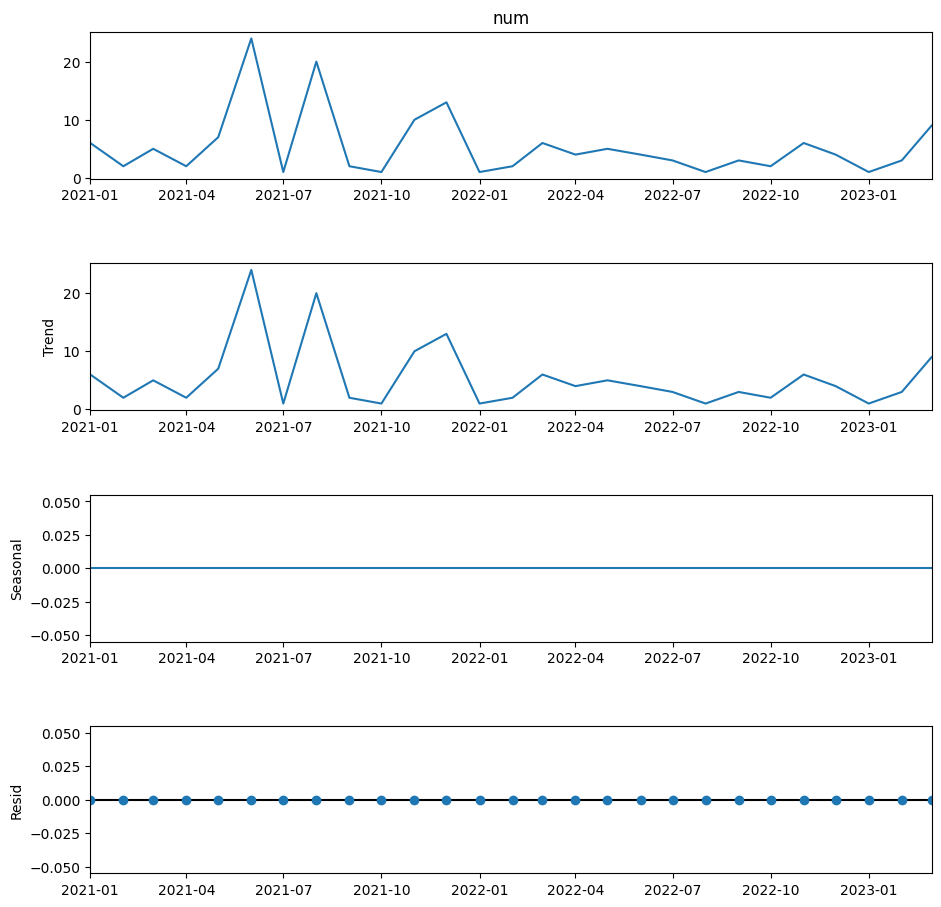

In [325]:
decomposition = sm.tsa.seasonal_decompose(df['num'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

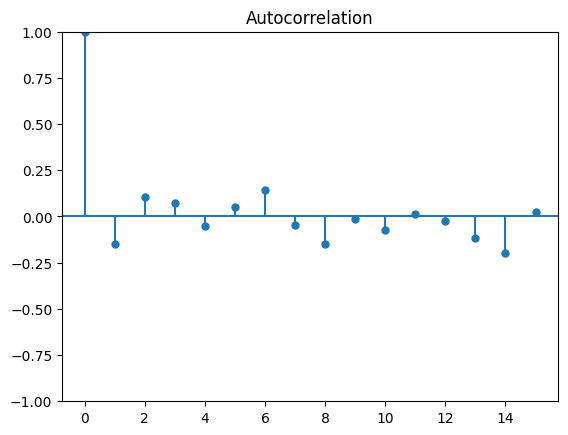

In [326]:
acf_chart(df['num'])

In [327]:
def tsplot(y, lags=12, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

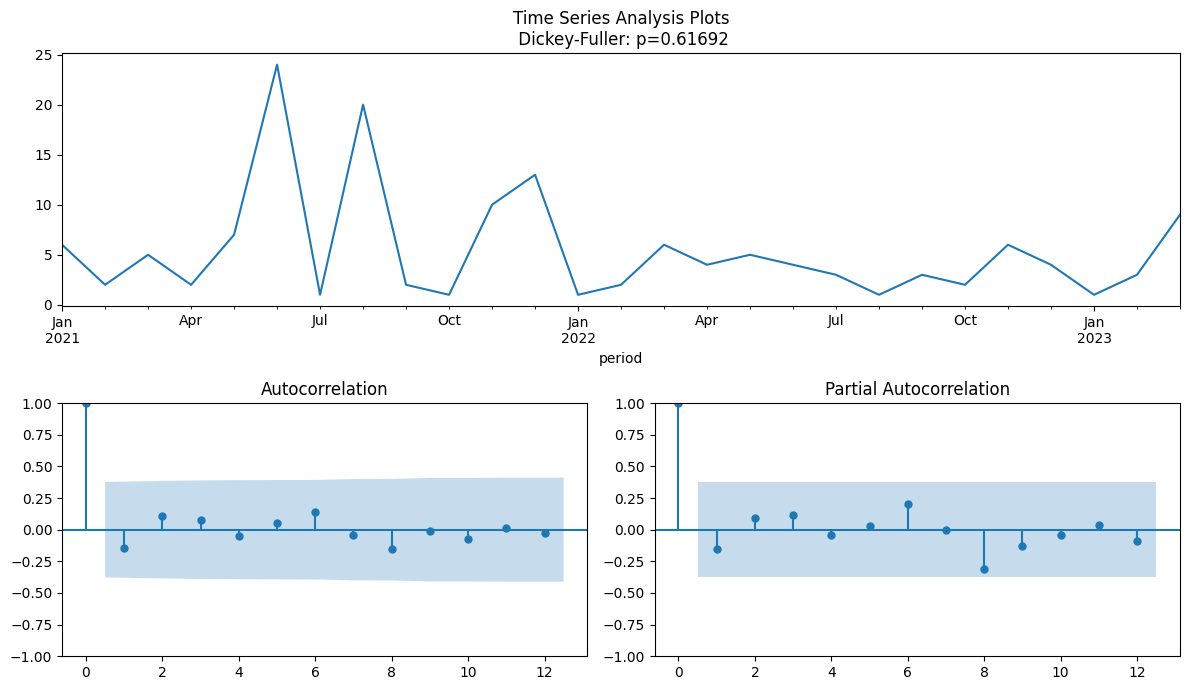

In [328]:
tsplot(df['num'])

In [329]:
adfuller(df['num'])

(-1.3265855125445087,
 0.6169233620381159,
 5,
 21,
 {'1%': -3.7883858816542486,
  '5%': -3.013097747543462,
  '10%': -2.6463967573696143},
 79.35992371668635)

In [330]:
y1_diff = df.diff().dropna()['num']   #diff의 디폴트 차분차수는 1이고.. 차분시 발생하는 짝이 없어서 발생하는 nan 데이터는 드랍한다.
y1_diff

period
2021-02-01    -4.0
2021-03-01     3.0
2021-04-01    -3.0
2021-05-01     5.0
2021-06-01    17.0
2021-07-01   -23.0
2021-08-01    19.0
2021-09-01   -18.0
2021-10-01    -1.0
2021-11-01     9.0
2021-12-01     3.0
2022-01-01   -12.0
2022-02-01     1.0
2022-03-01     4.0
2022-04-01    -2.0
2022-05-01     1.0
2022-06-01    -1.0
2022-07-01    -1.0
2022-08-01    -2.0
2022-09-01     2.0
2022-10-01    -1.0
2022-11-01     4.0
2022-12-01    -2.0
2023-01-01    -3.0
2023-02-01     2.0
2023-03-01     6.0
Name: num, dtype: float64

In [331]:
adfuller(y1_diff)

(-0.08206875277374856,
 0.9511955247473627,
 9,
 16,
 {'1%': -3.9240193847656246, '5%': -3.0684982031250003, '10%': -2.67389265625},
 78.50085337626493)

In [332]:
# tsplot(y1_diff)

Augmented Dickey-Fuller Test
- adf : 검정통계량
- p value : 통상 p value가 0.05 보다 작아야 데이터가 stationary(움직이지 않는) 하다고 볼 수 있다.
- usedlag: 사용된 시차의 수
- nobs: 분석에 사용된 자료의 수
- critical values : 1%, 5%, 10% 수준에 해당되는 검정 통계량의 값

In [333]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [334]:
# Fit auto_arima function to dataset
stepwise_fit = auto_arima(df['num'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
# To print the summary
summary = stepwise_fit.summary()
summary

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=109.937, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=110.169, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=104.187, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=104.743, Time=0.42 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=105.457, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=106.109, Time=0.03 sec

Be

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   27
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -50.094
Date:                            Fri, 28 Apr 2023   AIC                            104.187
Time:                                    09:34:53   BIC                            105.465
Sample:                                01-01-2021   HQIC                           104.069
                                     - 03-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6320      0.188     -3.369      0.001      -1.000      -0.264
sigma2        72.3819     27.651      2.618      0.009      18.187     126.577
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.44   Prob(JB):                         0.35
Heteroskedasticity (H):               0.38   Skew:                            -0.92
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [335]:
get_parametes = stepwise_fit.get_params()
get_parametes

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [336]:
order = get_parametes["order"]
seasonal_order = get_parametes["seasonal_order"]
order, seasonal_order

((1, 1, 0), (0, 1, 0, 12))

In [337]:
train = df.iloc[:24]
test = df.iloc[24:]

In [338]:
# train, test

In [339]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['num'], 
                order = order, 
                seasonal_order = seasonal_order)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                num   No. Observations:                   24
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -40.252
Date:                            Fri, 28 Apr 2023   AIC                             84.505
Time:                                    09:34:53   BIC                             85.301
Sample:                                01-01-2021   HQIC                            84.003
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6425      0.223     -2.879      0.004      -1.080      -0.205
sigma2        84.1304     38.463      2.187      0.029       8.744     159.517
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.45   Prob(JB):                         0.73
Heteroskedasticity (H):               6.47   Skew:                            -0.58
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: xlabel='period'>

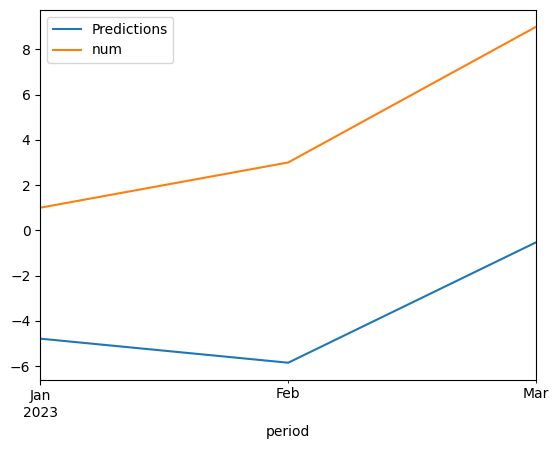

In [340]:
start = len(train)
end = len(train) + len(test) - 1
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
# plot predictions and actual values
predictions.plot(legend = True)
test['num'].plot(legend = True)

In [341]:
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
# Calculate root mean squared error
rmse(test["num"], predictions)
# Calculate mean squared error
mean_squared_error(test["num"], predictions)

67.52784223670514

<AxesSubplot: xlabel='period'>

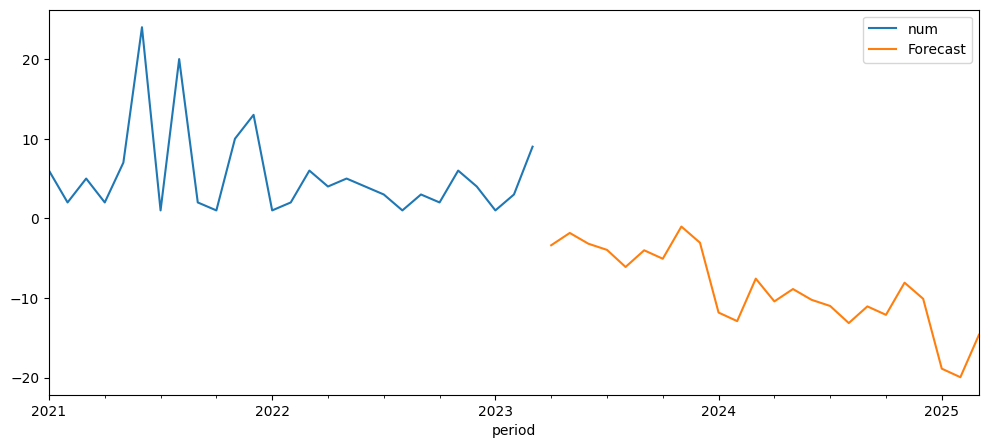

In [342]:
# Train the model on the full dataset
# model = SARIMAX(df['num'], order = order, seasonal_order =seasonal_order)
# result = model.fit()
# Forecast for the next 3 years
forecast = result.predict(start = len(df), 
                          end = (len(df)-1) + 2 * 12, 
                          typ = 'levels').rename('Forecast')
# Plot the forecast values
df['num'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [343]:
df['num']

period
2021-01-01     6
2021-02-01     2
2021-03-01     5
2021-04-01     2
2021-05-01     7
2021-06-01    24
2021-07-01     1
2021-08-01    20
2021-09-01     2
2021-10-01     1
2021-11-01    10
2021-12-01    13
2022-01-01     1
2022-02-01     2
2022-03-01     6
2022-04-01     4
2022-05-01     5
2022-06-01     4
2022-07-01     3
2022-08-01     1
2022-09-01     3
2022-10-01     2
2022-11-01     6
2022-12-01     4
2023-01-01     1
2023-02-01     3
2023-03-01     9
Name: num, dtype: int64

In [344]:
forecast.round()

2023-04-01    -3.0
2023-05-01    -2.0
2023-06-01    -3.0
2023-07-01    -4.0
2023-08-01    -6.0
2023-09-01    -4.0
2023-10-01    -5.0
2023-11-01    -1.0
2023-12-01    -3.0
2024-01-01   -12.0
2024-02-01   -13.0
2024-03-01    -8.0
2024-04-01   -10.0
2024-05-01    -9.0
2024-06-01   -10.0
2024-07-01   -11.0
2024-08-01   -13.0
2024-09-01   -11.0
2024-10-01   -12.0
2024-11-01    -8.0
2024-12-01   -10.0
2025-01-01   -19.0
2025-02-01   -20.0
2025-03-01   -15.0
Freq: MS, Name: Forecast, dtype: float64